In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from skimage.transform import resize
import CA_model
import iceing
import evaluation
import initial_distributions
from tqdm import tqdm

In [2]:
# make a color map of fixed colors
cmap = colors.ListedColormap(['cyan', 'white', 'blue'])
bounds=[-100,0.5,3,100]
norm = colors.BoundaryNorm(bounds, cmap.N)

## CA model

In [3]:
# size = 1000

# Ht_0 = np.random.normal(loc = 0.15, scale = 0.1, size = (int(size/3), int(size/3)))
# Ht_0 = resize(Ht_0, (size, size))
# Ht_0 = np.heaviside(Ht_0, 0) * Ht_0 + 0.1

# # Ht_0 = np.random.normal(loc = 0.15, scale = 0.1, size = (size, size))
# h = np.zeros(shape = (size, size))


In [4]:
# initialize model with 'snow dune topography' Popovic et al., 2020

res = 500                       # size of the domain
mode = 'snow_dune'              # topography type
tmax = 2; dt = 0.1              # diffusion time and time-step if mode = 'diffusion' or mode = 'rayleigh'
g = 1                           # anisotropy parameter
sigma_h = 0.03                  # surface standard deviation
snow_dune_radius = 1.           # mean snow dune radius if mode = 'snow_dune'  
Gaussians_per_pixel = 0.2       # density of snow dunes if mode = 'snow_dune'  
snow_dune_height_exponent = 1.  # exponent that relates snow dune radius and snow dune height if mode = 'snow_dune'

mean_freeboard = 0.1

Tdrain = 10.; dt_drain = 0.5    # time and time-step of to drainage

# create topography
Ht_0 = initial_distributions.Create_Initial_Topography(res = res, mode = mode, tmax = tmax, dt = dt, g = g, sigma_h = sigma_h, h = mean_freeboard, snow_dune_radius = snow_dune_radius, 
            Gaussians_per_pixel = Gaussians_per_pixel, number_of_r_bins = 150, window_size = 5, snow_dune_height_exponent = snow_dune_height_exponent)


size = res
h = np.zeros(shape = (size, size))

/Users/nik/opt/miniconda3/envs/IntroCLS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nik/opt/miniconda3/envs/IntroCLS/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


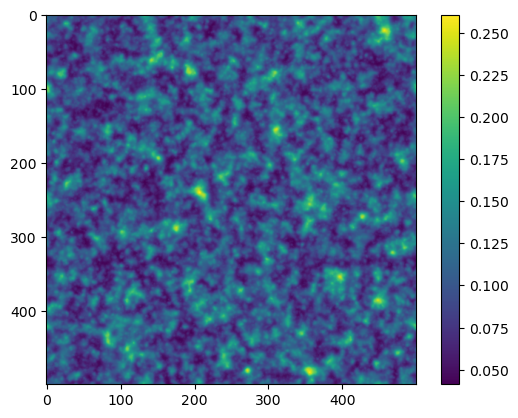

In [5]:
plt.imshow(Ht_0)
plt.colorbar()

In [6]:
Ht_0.min()

0.04133292399329819

In [7]:
ca_model = CA_model.CA_model(Ht_0, h, dt = 15, dx = 1, periodic_bounds=False)
# ca_model.H[ca_model.psi == ca_model.psi.min()] = 0
hs = []
Hs = []
Hts = []
# hes = []

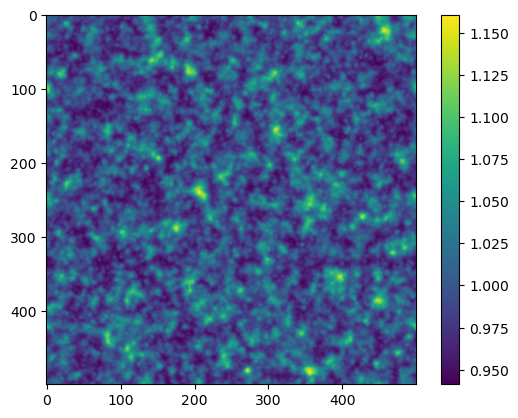

In [8]:
plt.imshow(ca_model.H)
plt.colorbar()

In [10]:
experiment_name = "Test4plotting_full_thickness"
iterations = 1440 # 6h @ 15s/iteration

for i in tqdm(range(400), leave=False):
    h, H, Ht = ca_model.run(iterations)
    #he = ca_model.equalize(500)
    # hs.append(h)
    # Hs.append(H)
    # Hts.append(Hts)

    np.save(f"experiments/{experiment_name}/pond/_i={i}",ca_model.h)
    np.save(f"experiments/{experiment_name}/ice/_i={i}",ca_model.H)
    np.save(f"experiments/{experiment_name}/freeboard/_i={i}",ca_model.Ht)

    #hes.append(he)

 27%|██▋       | 108/400 [1:52:53<4:56:51, 61.00s/it]

In [ ]:
evaluation.make_plots("Test4plotting_full_thickness", threshold = 0.01)

In [ ]:
# for i, h in enumerate(hs):
#     plt.imshow(np.ma.masked_where(h<=0.01, h))
#     plt.colorbar()
#     #plt.imshow(h)
#     plt.savefig('test_figs/h_'+str(i*iterations)+'.png')
#     plt.clf()

<Figure size 640x480 with 0 Axes>

In [ ]:
index = 15

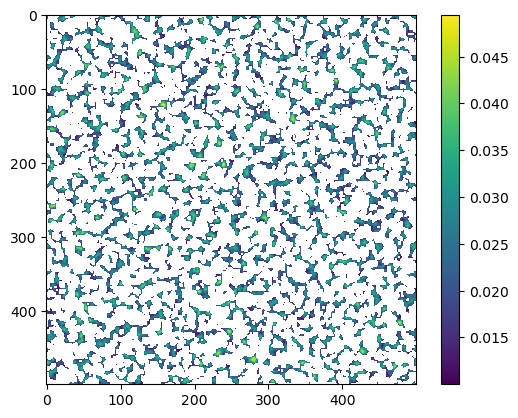

In [ ]:
plt.imshow(np.ma.masked_where(hs[index]<=0.01, hs[index]))
plt.colorbar()

In [ ]:
areas, perimeters = evaluation.perim_area(np.where(hs[index]>=0.01, -1, 1), pond_val = -1, ice_val = 1)

Text(0, 0.5, 'perimeter [m]')

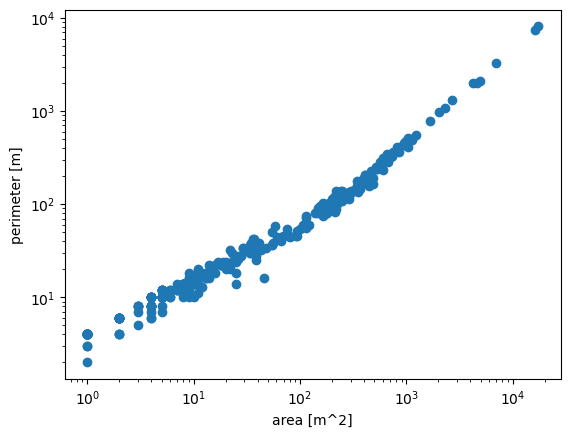

In [ ]:
plt.scatter(areas, perimeters)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('area [m^2]')
plt.ylabel('perimeter [m]')

In [ ]:
areas_dim, dimensions = evaluation.fractal_dim(np.where(hs[index]>=0.01, -1, 1), -1, 1, 150, min_area = 5)

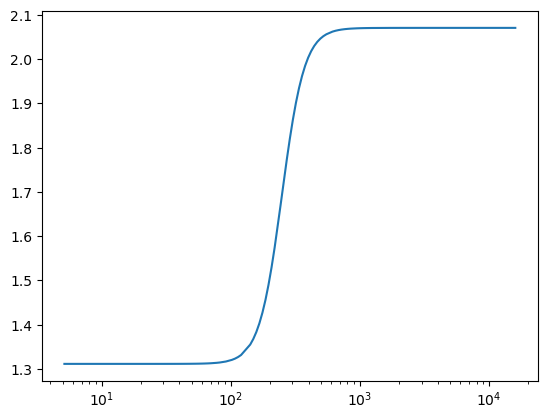

In [ ]:
plt.plot(areas_dim, dimensions)
plt.xscale('log')

In [ ]:
plt.imshow(np.ma.masked_where(hs[index]<=0.01, hs[index]))
plt.colorbar()

In [ ]:
for i, h in enumerate(hs):
    plot_array = np.where(Hs[i]>0, 1, 5)
    plot_array = np.where(hs[i]>0.02, 0, plot_array)
    plt.imshow(plot_array, cmap=cmap, norm=norm)
    plt.colorbar()
    #plt.imshow(h)
    plt.savefig('test_figs/h_high_res_'+str(i*iterations)+'.png')
    plt.clf()

<Figure size 640x480 with 0 Axes>

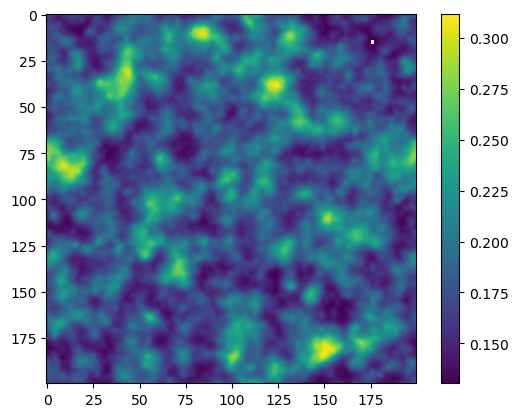

In [ ]:
plt.imshow(np.ma.masked_where(Hs[0]<=0, Hs[0]))
#plt.imshow(H)
plt.colorbar()

## Evaluation CA

In [ ]:
areas_ca, perimeters_ca = evaluation.perim_area(np.where(h>0.01, -1, 1), pond_val = -1, ice_val = 1)

Text(0, 0.5, 'perimeter [m]')

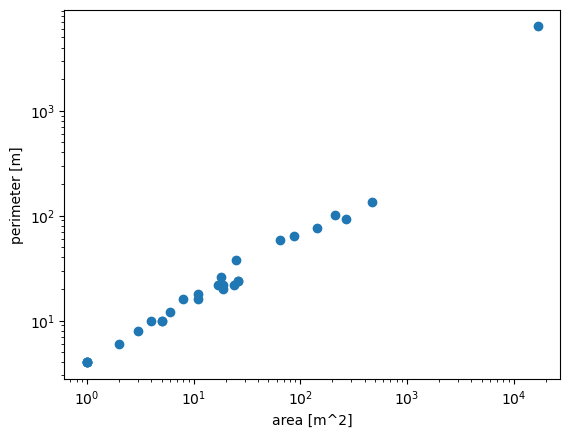

In [ ]:
plt.scatter(areas_ca, perimeters_ca)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('area [m^2]')
plt.ylabel('perimeter [m]')

## Ising model

In [ ]:
iceing_test = iceing.iceing_model(0.45, 1000)

In [ ]:
ponds, sums = iceing_test.run(15_000_000)

In [ ]:
# make a color map of fixed colors
cmap = colors.ListedColormap(['blue', 'white'])
bounds=[-100,0,100]
norm = colors.BoundaryNorm(bounds, cmap.N)

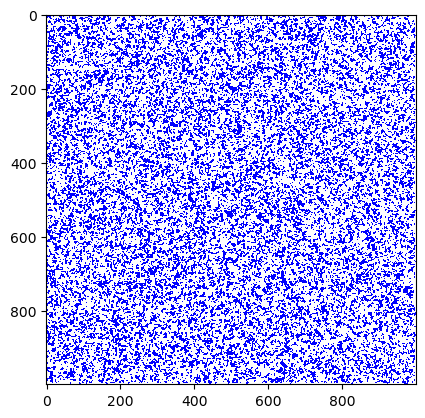

In [ ]:
# plot ponds
plt.imshow(ponds, cmap=cmap, norm=norm)

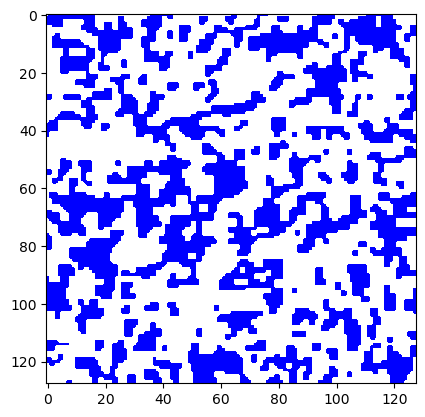

In [ ]:
# zoom in
plt.imshow(ponds[100:228,100:228], cmap=cmap, norm=norm)

## Evaluation Ising
Fractal dimension plot is still missing.

In [ ]:
areas_ising, perimeters_ising = evaluation.perim_area(ponds, pond_val = -1, ice_val = 1)

Text(0, 0.5, 'perimeter [m]')

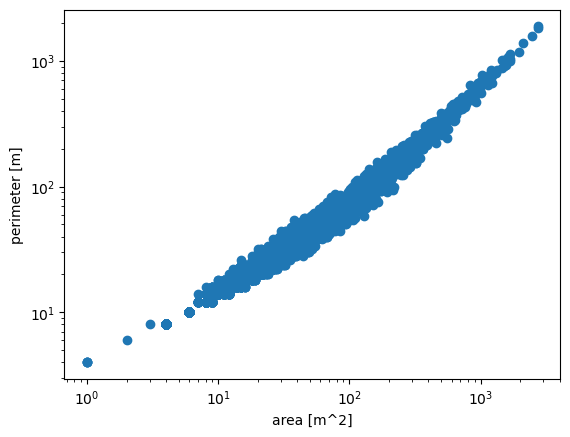

In [ ]:
plt.scatter(areas_ising, perimeters_ising)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('area [m^2]')
plt.ylabel('perimeter [m]')

In [ ]:
areas_dim, dimensions, areas_scatter, dimensions_scatter = evaluation.fractal_dim(ponds, -1, 1, 50)

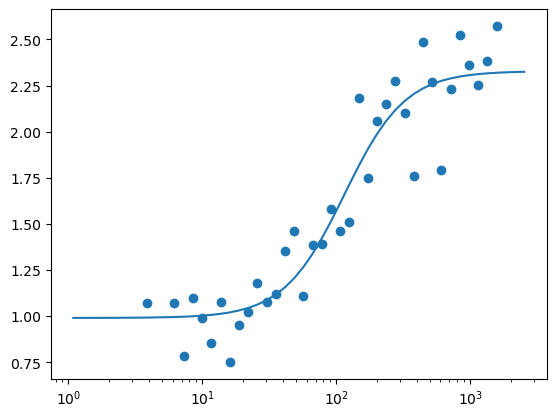

In [ ]:
plt.plot(areas_dim, dimensions)
plt.scatter(areas_scatter, dimensions_scatter)

plt.xscale('log')

## For fun
Just a normal distribution with the heaviside function.

In [ ]:
size = 1000
h_norm = np.random.normal(loc = 0.5, scale = 1, size = (int(size/3), int(size/3)))
h_norm = resize(h_norm, (size, size))
h_norm = np.heaviside(h_norm-0.6, 0) * h_norm

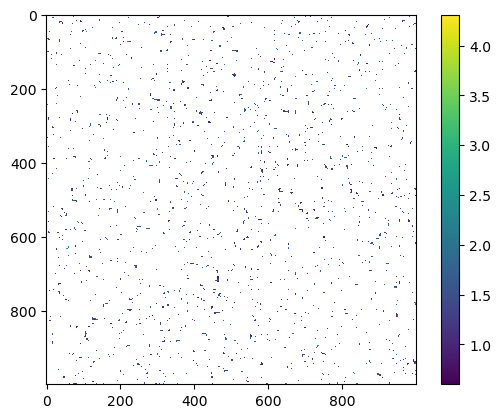

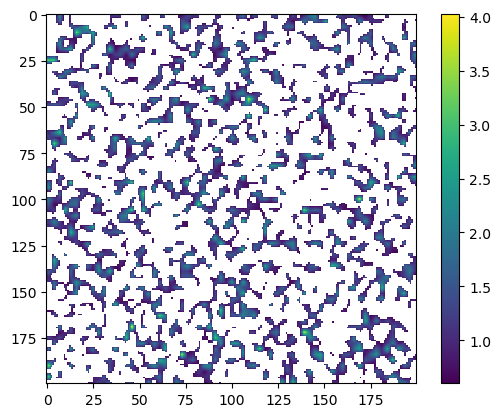

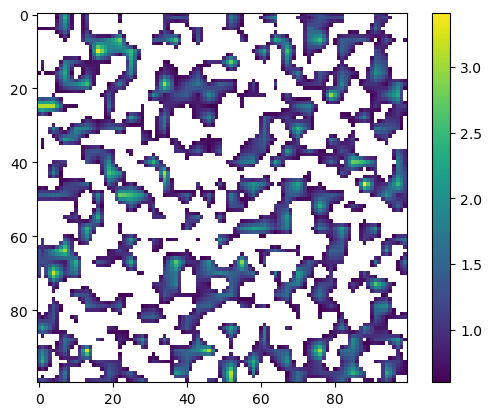

In [ ]:
plt.figure()
plt.imshow(np.ma.masked_where(h_norm<=0, h_norm))
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(np.ma.masked_where(h_norm[:200, :200]<=0, h_norm[:200, :200]))
plt.colorbar()
plt.show()
plt.imshow(np.ma.masked_where(h_norm[:100, :100]<=0, h_norm[:100, :100]))
plt.colorbar()
plt.show()

In [ ]:
areas_norm, perimeters_norm = evaluation.perim_area(np.where(h_norm>0, -1, 1), pond_val = -1, ice_val = 1)

Text(0, 0.5, 'perimeter [m]')

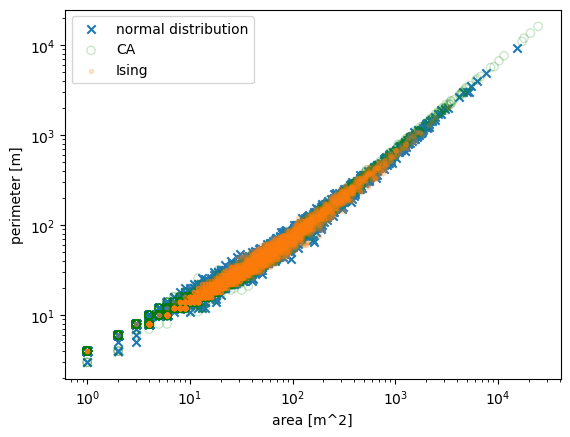

In [ ]:
plt.scatter(areas_norm, perimeters_norm, marker='x', label = 'normal distribution')
plt.scatter(areas_ca, perimeters_ca, facecolor='none', edgecolors='g', alpha=0.2, label = 'CA')
plt.scatter(areas_ising, perimeters_ising, marker='.', alpha=0.2, label = 'Ising')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('area [m^2]')
plt.ylabel('perimeter [m]')

/Users/nik/Library/CloudStorage/OneDrive-Personal/MSc_CLS/complex_system_simulation/ComplexSystemSimulation/evaluation.py:139: RuntimeWarning: overflow encountered in cosh
  return (a1 / (2 * a2)) * np.log(np.cosh(a2 * (x - a3))) + (a4 / 2) * x + a5
/Users/nik/opt/miniconda3/envs/IntroCLS/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/nik/Library/CloudStorage/OneDrive-Personal/MSc_CLS/complex_system_simulation/ComplexSystemSimulation/evaluation.py:204: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 6))


<Figure size 640x480 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

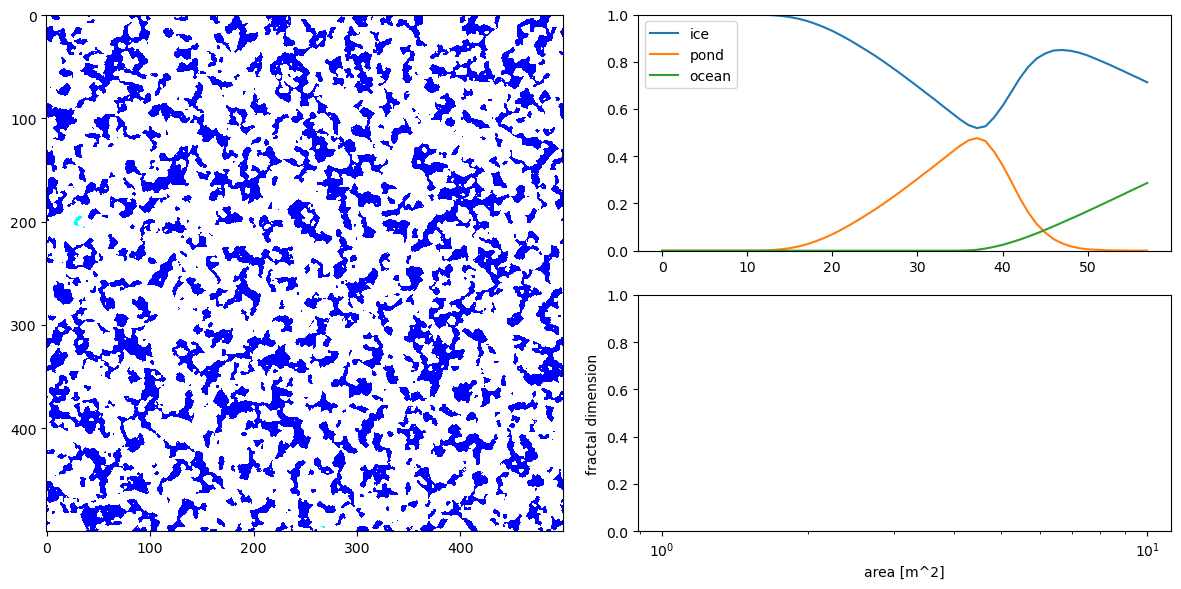

In [1]:
import evaluation
evaluation.make_plots("Test4plotting", threshold = 0.04)

In [ ]:
import re
# Define a function to extract the numeric part of the filename
def extract_number(filename):
    match = re.search(r"_i=(\d+)", filename)
    if match:
        return int(match.group(1))
    return -1   

In [9]:
import os
experiment_name = "Test4plotting"
filenames = os.listdir(f"experiments/{experiment_name}/pond")

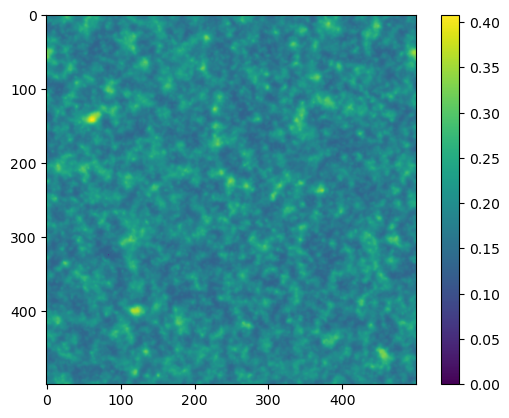

In [10]:
import numpy as np
import matplotlib.pyplot as plt 

plt.imshow(np.load(f"experiments/{experiment_name}/ice/_i=0.npy"))
plt.colorbar()